In [31]:
import sys
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from zipfile import ZipFile
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import bfseg.models.fast_scnn
import bfseg.data.hive.office_rumlang_validation_labeled
import bfseg.data.hive.bfseg_validation_labeled
from bfseg.utils.utils import load_gdrive_file
from bfseg.utils.metrics import IgnorantAccuracyMetric, IgnorantBalancedAccuracyMetric, IgnorantMeanIoU
#from bfseg.settings import TMPDIR
TMPDIR = "/home/matthias/data/rss_2021_data/tmp/"
MASKPATH = "/home/matthias/data/rss_2021_data/mask.png"
base_directory = '/home/matthias/data/rss_2021_data/final_models/'

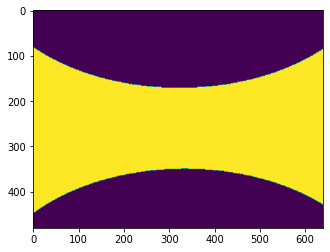

In [2]:
# Load mask
mask = plt.imread(MASKPATH)
ax = plt.subplot()
ax.imshow(mask)
mask_filtered = np.nonzero(mask)
test = mask[mask_filtered]

In [3]:
val_ds_office_gt = tfds.load('office_rumlang_validation_labeled', split='OFFICE')

# Single Task

In [83]:
# Pretraining NYU
#model0 = tf.keras.models.load_model(os.path.join(base_directory, 'nyu_pretraining_10/model_epoch_10.h5'))
# Finetuning Sparse
#model0 = tf.keras.models.load_model(os.path.join(base_directory, 'office3_sparse50_dyn_cam2_finetuning_10/model_epoch_10.h5'))
# Finetuning Dense
#model0 = tf.keras.models.load_model(os.path.join(base_directory, 'office3_dense20_dyn_cam2_finetuning_05/model_epoch_5.h5'))
# Finetuning Combined
model0 = tf.keras.models.load_model(os.path.join(base_directory, 'office3_combined2050_dyn_cam2_finetuning_06/model_epoch_6.h5'))

In [84]:
miou = tf.keras.metrics.MeanIoU(num_classes=2)
acc = tf.keras.metrics.Accuracy()
bacc = IgnorantBalancedAccuracyMetric(class_to_ignore=2, num_classes=2)
#miou2 = IgnorantMeanIoU(class_to_ignore=None, num_classes=2)
for batch in val_ds_office_gt.batch(1):
    a = tf.image.convert_image_dtype(batch['image'], tf.float32)
    b = model0(a)[1]
    pred = tf.argmax(b, axis=-1)
    expanded_mask = tf.expand_dims(mask, -1)
    expanded_mask = tf.expand_dims(expanded_mask, 0)
    masked_labels = tf.where(expanded_mask==1, batch['label'], tf.constant(2, dtype=tf.uint8))
    miou.update_state(batch['label'], pred, mask)
    acc.update_state(batch['label'], pred, tf.expand_dims(mask,0))
    bacc.update_state(masked_labels, b)
print("With mask: mIoU: {}, acc: {}, bacc: {}".format(miou.result(), acc.result(), bacc.result()))

miou = tf.keras.metrics.MeanIoU(num_classes=2)
acc = tf.keras.metrics.Accuracy()
bacc = IgnorantBalancedAccuracyMetric(class_to_ignore=None, num_classes=2)
for batch in val_ds_office_gt.batch(1):
    a = tf.image.convert_image_dtype(batch['image'], tf.float32)
    b = model0(a)[1]
    pred = tf.argmax(b, axis=-1)
    miou.update_state(batch['label'], pred)
    acc.update_state(batch['label'], pred)
    bacc.update_state(batch['label'], b)
    #miou2.update_state(batch['label'], b)
print("Without mask: mIoU: {}, acc: {}, bacc: {}".format(miou.result(), acc.result(), bacc.result(), miou2.result()))

With mask: mIoU: 0.5270905494689941, acc: 0.6995412707328796, bacc: 0.7174856066703796
Without mask: mIoU: 0.5491838455200195, acc: 0.7103727459907532, bacc: 0.7356137633323669


# Multi-Task (with depth)

In [108]:
# Pretraining power + std
#model0 = tf.keras.models.load_model(os.path.join(base_directory, 'nyu_depth_pretraining_power_std_65/model_epoch_65.h5'))
# Pretraining power + median
#model0 = tf.keras.models.load_model(os.path.join(base_directory, 'nyu_depth_pretraining_power_median_55/model_epoch_55.h5'))
# Pretraining inverse + std
#model0 = tf.keras.models.load_model(os.path.join(base_directory, 'nyu_depth_pretraining_inverse_std_25/model_epoch_25.h5'))
# Pretraining inverse + median
#model0 = tf.keras.models.load_model(os.path.join(base_directory, 'nyu_depth_pretraining_inverse_median_45/model_epoch_45.h5'))
# Pretraining power + std (no consistency)
#model0 = tf.keras.models.load_model(os.path.join(base_directory, 'nyu_depth_pretraining_power_std_nocons_40/model_epoch_40.h5'))
# Pretraining power + std (no depth)
#model0 = tf.keras.models.load_model(os.path.join(base_directory, 'nyu_depth_pretraining_power_std_nodepth_25/model_epoch_25.h5'))
# Pretraining DORN
#model0 = tf.keras.models.load_model(os.path.join(base_directory, 'nyu_dorn_pretraining_60/model_epoch_60.h5'))

# Finetuning power + std
model0 = tf.keras.models.load_model(os.path.join(base_directory, 'office3_densedepth20_dyn_cam2_finetuning_power_std_06/model_epoch_6.h5'))
# Finetuning power + median
#model0 = tf.keras.models.load_model(os.path.join(base_directory, 'office3_densedepth20_dyn_cam2_finetuning_power_median_00/model_epoch_0.h5'))
# Finetuning inverse + std
#model0 = tf.keras.models.load_model(os.path.join(base_directory, 'office3_densedepth20_dyn_cam2_finetuning_inverse_std_15/model_epoch_15.h5'))
# Finetuning inverse + median
#model0 = tf.keras.models.load_model(os.path.join(base_directory, 'office3_densedepth20_dyn_cam2_finetuning_inverse_median_15/model_epoch_15.h5'))
# Finetuning power + std (no consistency)
#model0 = tf.keras.models.load_model(os.path.join(base_directory, 'office3_densedepth20_dyn_cam2_finetuning_power_std_nocons_10/model_epoch_10.h5'))
# Finetuning power + std (no depth)
#model0 = tf.keras.models.load_model(os.path.join(base_directory, 'office3_densedepth20_dyn_cam2_finetuning_power_std_nodepth_04/model_epoch_4.h5'))
# Finetuning DORN
#model0 = tf.keras.models.load_model(os.path.join(base_directory, 'office3_densedepth20_dyn_cam2_finetuning_dorn_03/model_epoch_3.h5'))

In [109]:
miou = tf.keras.metrics.MeanIoU(num_classes=2)
acc = tf.keras.metrics.Accuracy()
bacc = IgnorantBalancedAccuracyMetric(class_to_ignore=2, num_classes=2)
#miou2 = IgnorantMeanIoU(class_to_ignore=None, num_classes=2)
for batch in val_ds_office_gt.batch(1):
    a = tf.image.convert_image_dtype(batch['image'], tf.float32)
    b = model0(a)[1][0]
    pred = tf.argmax(b, axis=-1)
    expanded_mask = tf.expand_dims(mask, -1)
    expanded_mask = tf.expand_dims(expanded_mask, 0)
    masked_labels = tf.where(expanded_mask==1, batch['label'], tf.constant(2, dtype=tf.uint8))
    miou.update_state(batch['label'], pred, mask)
    acc.update_state(batch['label'], pred, tf.expand_dims(mask,0))
    bacc.update_state(masked_labels, b)
print("With mask: mIoU: {}, acc: {}, bacc: {}".format(miou.result(), acc.result(), bacc.result()))

miou = tf.keras.metrics.MeanIoU(num_classes=2)
acc = tf.keras.metrics.Accuracy()
bacc = IgnorantBalancedAccuracyMetric(class_to_ignore=None, num_classes=2)
for batch in val_ds_office_gt.batch(1):
    a = tf.image.convert_image_dtype(batch['image'], tf.float32)
    b = model0(a)[1][0]
    pred = tf.argmax(b, axis=-1)
    miou.update_state(batch['label'], pred)
    acc.update_state(batch['label'], pred)
    bacc.update_state(batch['label'], b)
    #miou2.update_state(batch['label'], b)
print("Without mask: mIoU: {}, acc: {}, bacc: {}".format(miou.result(), acc.result(), bacc.result(), miou2.result()))

With mask: mIoU: 0.5211955308914185, acc: 0.705742359161377, bacc: 0.6738595962524414
Without mask: mIoU: 0.546749472618103, acc: 0.7120764255523682, bacc: 0.7186862826347351
